In [ ]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('MSFT.csv')

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-07-14,347.589996,351.429993,344.309998,345.239990,342.560242,28302200
1,2023-07-17,345.679993,346.989990,342.200012,345.730011,343.046448,20363900
2,2023-07-18,345.829987,366.779999,342.170013,359.489990,356.699615,64872700
3,2023-07-19,361.750000,362.459991,352.440002,355.079987,352.323883,39732900
4,2023-07-20,353.570007,357.970001,345.369995,346.869995,344.177612,33778400
...,...,...,...,...,...,...,...
246,2024-07-08,466.549988,467.700012,464.459991,466.239990,466.239990,12962300
247,2024-07-09,467.000000,467.329987,458.000000,459.540009,459.540009,17207200
248,2024-07-10,461.220001,466.459991,458.859985,466.250000,466.250000,18196100
249,2024-07-11,462.980011,464.779999,451.549988,454.700012,454.700012,23111200


In [ ]:
# lets consider the closing price variable:

df = df[['Date', 'Close']]

In [ ]:
df

,Date,Close
0,2023-07-14,345.239990
1,2023-07-17,345.730011
2,2023-07-18,359.489990
3,2023-07-19,355.079987
4,2023-07-20,346.869995
...,...,...
246,2024-07-08,466.239990
247,2024-07-09,459.540009
248,2024-07-10,466.250000
249,2024-07-11,454.700012


In [ ]:
# Note 'Date' is a string of ymd but not the actual date column
df['Date']

0      2023-07-14
1      2023-07-17
2      2023-07-18
3      2023-07-19
4      2023-07-20
          ...    
246    2024-07-08
247    2024-07-09
248    2024-07-10
249    2024-07-11
250    2024-07-12
Name: Date, Length: 251, dtype: object

In [ ]:
import datetime

In [ ]:
# converting to datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [ ]:
# creating a datetime object
datetime_object = str_to_datetime('2024-07-10')
datetime_object

datetime.datetime(2024, 7, 10, 0, 0)

In [ ]:
# now lets make all of the strings in the data into date time objects:

df['Date'] = df['Date'].apply(str_to_datetime)

<ipython-input-11-ea7676a4f010>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [ ]:
# setting date to index:

df.index = df.pop('Date')

In [ ]:
# now the date column is the index:
df

,Close
Date,
2023-07-14,345.239990
2023-07-17,345.730011
2023-07-18,359.489990
2023-07-19,355.079987
2023-07-20,346.869995
...,...
2024-07-08,466.239990
2024-07-09,459.540009
2024-07-10,466.250000


In [ ]:
# let's plot out data:

import matplotlib.pyplot as plt

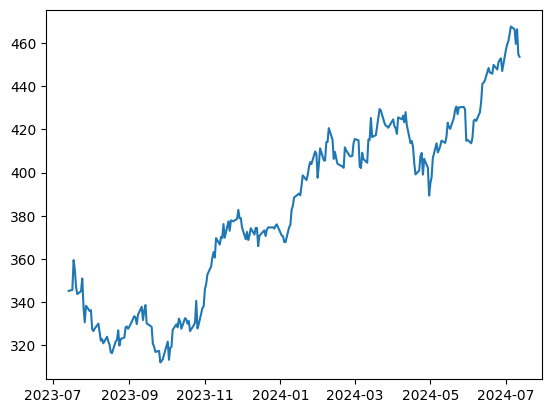

In [ ]:
# 1 year data for MSFT:

plt.plot(df.index, df['Close'])

In [ ]:
# because we are using an LSTM model, we need to convert this into a supervised learning problem:
# make a new function for windows:
import numpy as np

In [ ]:
def str_to_datetime(date_str):
    return datetime.datetime.strptime(date_str, '%Y-%m-%d')

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if next_week.empty:
            print(f'Error: No data available for the week starting from {target_date}')
            return

        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        next_date = datetime.datetime.strptime(next_date_str, '%Y-%m-%d')

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

In [ ]:
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2023-07-19',
                                '2024-07-12',
                                n=3)
windowed_df
# this will create 3 day windowed df for every day in the time frame (the year)
# target is the desired output, hence the name

,Target Date,Target-3,Target-2,Target-1,Target
0,2023-07-19,345.239990,345.730011,359.489990,355.079987
1,2023-07-20,345.730011,359.489990,355.079987,346.869995
2,2023-07-21,359.489990,355.079987,346.869995,343.769989
3,2023-07-24,355.079987,346.869995,343.769989,345.109985
4,2023-07-25,346.869995,343.769989,345.109985,350.980011
...,...,...,...,...,...
243,2024-07-08,459.279999,460.769989,467.559998,466.239990
244,2024-07-09,460.769989,467.559998,466.239990,459.540009
245,2024-07-10,467.559998,466.239990,459.540009,466.250000
246,2024-07-11,466.239990,459.540009,466.250000,454.700012


<Axes: >

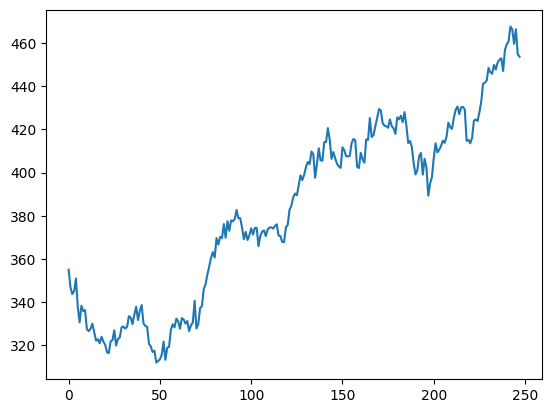

In [ ]:
# We have converted this into a supervised learning problem:
windowed_df['Target'].plot()

In [ ]:
# Now, we must convert the df into a np array to feed it into the model:
# return dates, X (input matrix), y (output vector):

def windowed_df_to_date_X_y(windowed_df):
  df_as_np = windowed_df.to_numpy()
  # to get the dates:
  dates = df_as_np[:,0]

  # to get the input matrix:
  middle_matrix = df_as_np[:,1:-1]
  # this is actually not in the right shape:
  # 1st dim = len dates -> # observations, 2nd dim -> middle matrix columns,
  # 3rd dim = 1 -> since we are only using 1 variable -> univiate forecasting (only use Closing Value), would be 2,3,4 if we used more variables:
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  # to get the output vector
  y = df_as_np[:,-1]

# to prevent an error, use astype()
  return dates, X.astype(np.float32), y.astype(np.float32)

In [ ]:
dates, X , y = windowed_df_to_date_X_y(windowed_df)

In [ ]:
print(dates.shape, X.shape, y.shape)
# for X, the shape is (248 samples, 3 steps in the past, 1 predicted variable)

(248,) (248, 3, 1) (248,)


In [ ]:
# Splitting the data into train, test, validation
q_80 = int(len(dates) * .8) # 1st 80% to training
q_90 = int(len(dates) * .9)

# training data
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

# validation data: 10% validation data from 80% to 90%
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

# test data: final 10 % from 90% up
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]


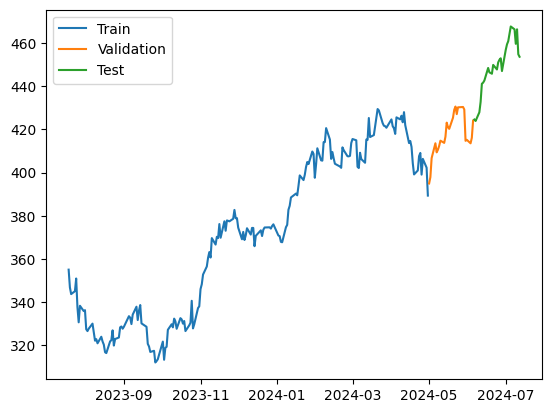

In [ ]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

# adding a legend:

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
# Building the model:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras


In [ ]:
'''# we will use Sequential API
# we must specify the input shape: don't need to specify the batch number => ((3,1)) 3 days in the past, 1 predicted feature

model = Sequential([layers.Input((3,1)),
                    layers.LSTM((256), return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),
                    layers.LSTM(256, return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),
                    layers.LSTM(256, return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),
                    layers.LSTM(256, return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),
                    layers.LSTM(256, return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),
                    layers.LSTM(256, return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),
                    layers.LSTM(256, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),
                    layers.Dense(256, activation = 'relu', kernel_regularizer = keras.regularizers.l2(l2=0.01)),
                    layers.Dense(256, activation = 'relu', kernel_regularizer = keras.regularizers.l2(l2=0.01)),
                    layers.Dense(256, activation = 'relu', kernel_regularizer = keras.regularizers.l2(l2=0.01)),
                    layers.Dense(256, activation = 'relu', kernel_regularizer = keras.regularizers.l2(l2=0.01)),
                    layers.Dense(256, activation = 'relu', kernel_regularizer = keras.regularizers.l2(l2=0.01)),
                    layers.Dense(1, activation = 'linear')]) # the default activation function is still linear though'''


"# we will use Sequential API\n# we must specify the input shape: don't need to specify the batch number => ((3,1)) 3 days in the past, 1 predicted feature\n\nmodel = Sequential([layers.Input((3,1)),\n                    layers.LSTM((256), return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),\n                    layers.LSTM(256, return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),\n                    layers.LSTM(256, return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),\n                    layers.LSTM(256, return_sequences= True, dropout= 0.2, kernel_regularizer= keras.regularizers.l2(l2=0.01), recurrent_regularizer= keras.regularizers.l2(l2=0.01)),\n                    layers.LSTM(256, return_sequences= True, 

In [ ]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

In [ ]:
# compiling the model:
# loss of choice for the task is Mean Squared Error
# MAE is the average amount of how off the prediction is,
# although we need to minimize MSE, as MAE is NOT DIFFERENTIABLE

model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.001), metrics = ['mean_absolute_error'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20065 (78.38 KB)
Trainable params: 20065 (78.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# plotting the model:
from keras.utils import plot_model

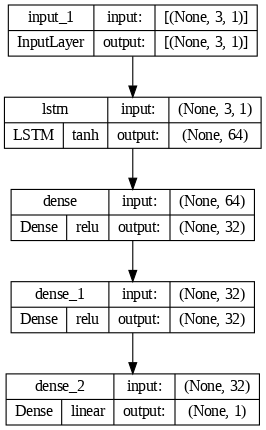

In [ ]:
plot_model(model, show_shapes = True, show_layer_names= True, show_layer_activations= True, dpi = 80)

In [ ]:
# fitting the model:

model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs= 200)

Epoch 1/200
7/7 [==============================] - 8s 115ms/step - loss: 137897.9688 - mean_absolute_error: 369.5235 - val_loss: 173734.7969 - val_mean_absolute_error: 416.7079
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 137545.6562 - mean_absolute_error: 369.0441 - val_loss: 173339.2344 - val_mean_absolute_error: 416.2330
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 137161.8438 - mean_absolute_error: 368.5249 - val_loss: 172766.8438 - val_mean_absolute_error: 415.5448
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 136529.2188 - mean_absolute_error: 367.6655 - val_loss: 171925.9062 - val_mean_absolute_error: 414.5318
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 135806.7031 - mean_absolute_error: 366.6803 - val_loss: 171041.8438 - val_mean_absolute_error: 413.4640
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 134876.5312 - mean_absolute_error: 365.4123 - v

In [ ]:
train_predictions = model.predict(X_train).flatten()

7/7 [==============================] - 1s 4ms/step


In [ ]:
import matplotlib.dates as mdates

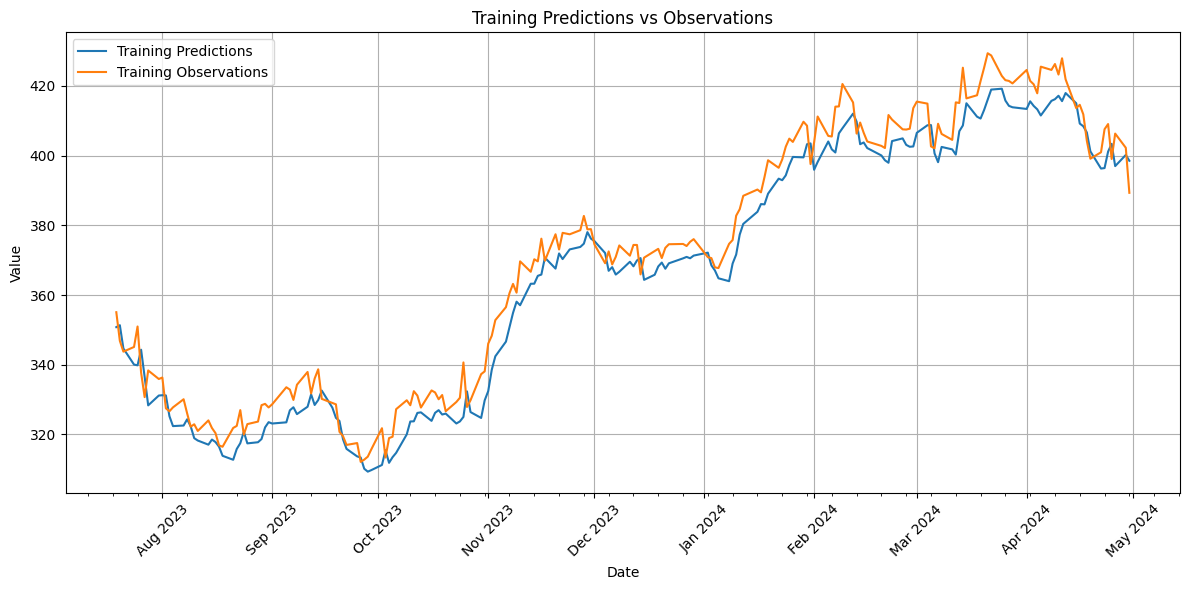

In [ ]:
# we only really care about the validation MAE,
# let's visualize this:

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')

# Formatting the x-axis to display dates nicely
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks every month
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator())  # Minor ticks every week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format major ticks as 'Month Year'

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Training Predictions vs Observations')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

In [ ]:
val_predictions = model.predict(X_val).flatten()

1/1 [==============================] - 0s 22ms/step


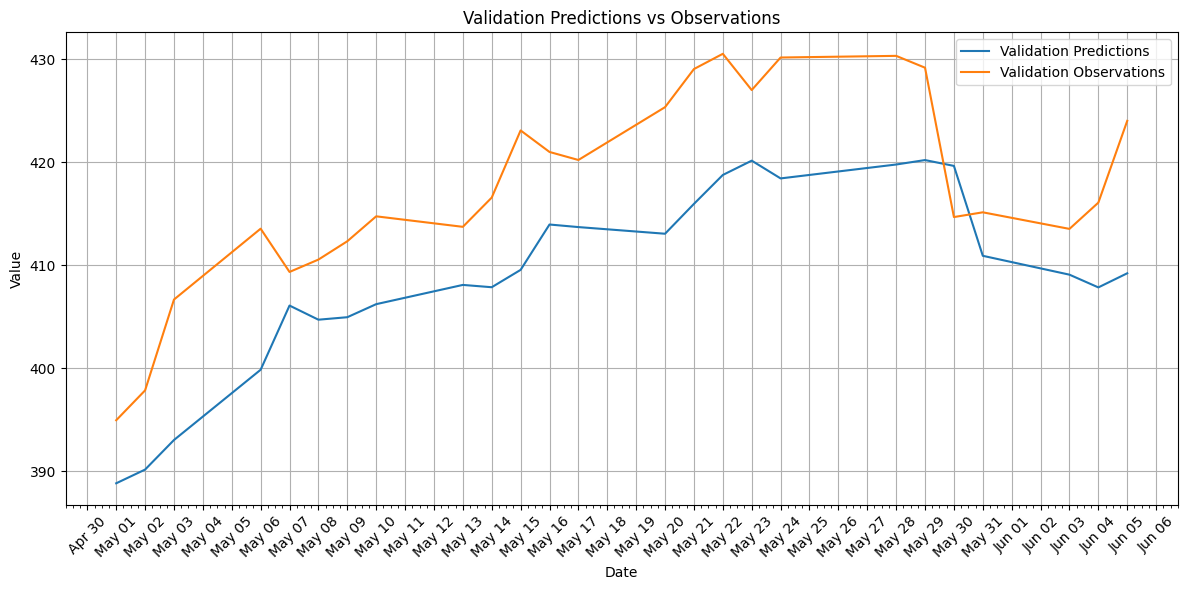

In [ ]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')

# Formatting the x-axis to display dates nicely
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Major ticks every day
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=6))  # Minor ticks every 6 hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format major ticks as 'Month Day'

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Validation Predictions vs Observations')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

In [ ]:
test_predictions = model.predict(X_test).flatten()

1/1 [==============================] - 0s 23ms/step


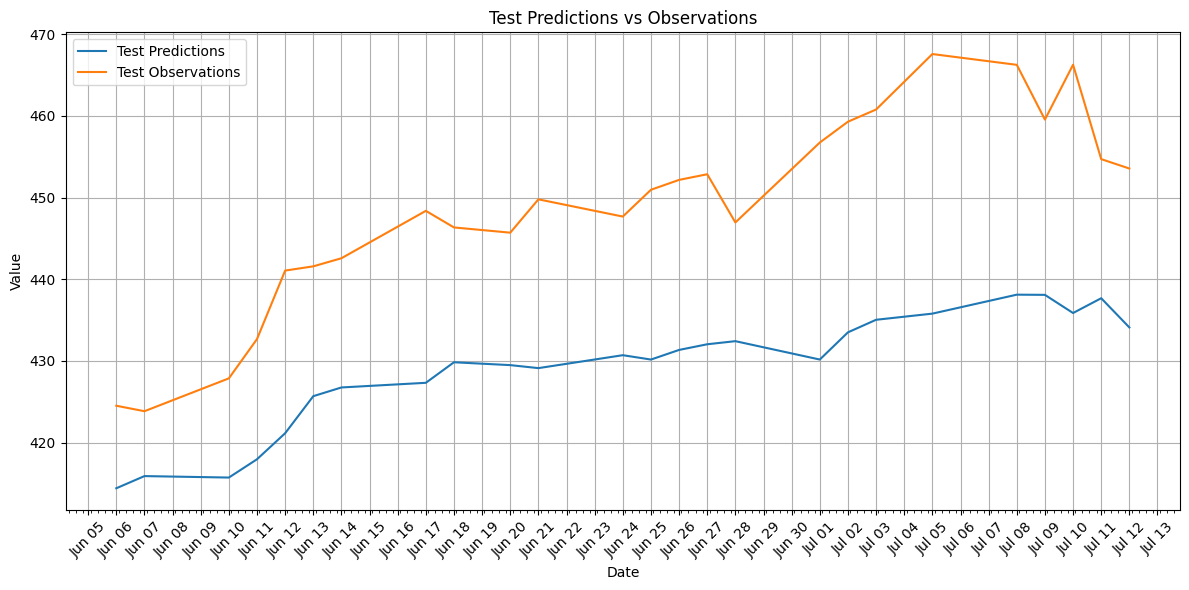

In [ ]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_predictions, label='Test Predictions')
plt.plot(dates_test, y_test, label='Test Observations')

# Formatting the x-axis to display dates nicely
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Major ticks every day
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=6))  # Minor ticks every 6 hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format major ticks as 'Month Day'

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Test Predictions vs Observations')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

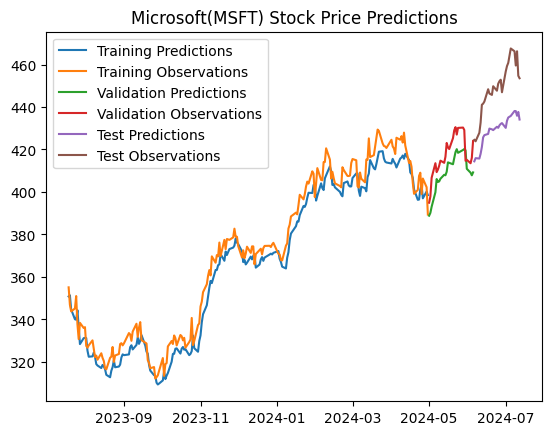

In [ ]:
# putting it all together:
# recall that the data split is 85-10-5 for train-val-test

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Test Predictions', 'Test Observations'])
plt.title('Microsoft(MSFT) Stock Price Predictions')
plt.show()

# One can infer that LSTMs are bad at extrapolating = learning data outside model's given range
# again, be mindful of what data and how much of it you feed it.

## We could end here, but let's use the model to recursively predict the future values beyond the training data.

In [44]:
# we will now let the model recursively predict the future:

from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction


1/1 [==============================] - 0s 24ms/step


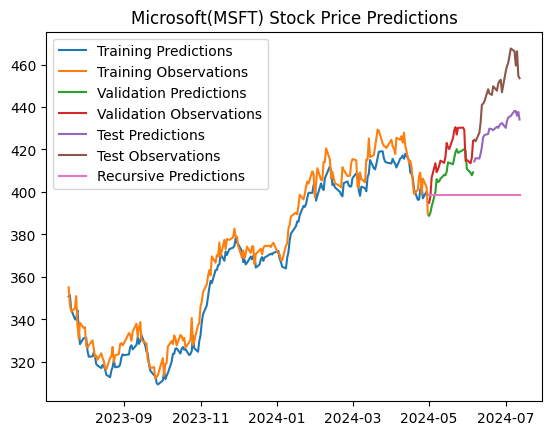

In [45]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions',
            'Validation Observations', 'Test Predictions',
            'Test Observations', 'Recursive Predictions'])
plt.title('Microsoft(MSFT) Stock Price Predictions')
plt.show()

# beware however that the model is unaware of future forecasting other than the last price it has seen.